# BDD Assignment #1

The goal of this problem set is to replicate and extend the core results of  Jean et al.'s 2016 paper, "Combining satellite imagery and machine learning to predict poverty." This problem set will be challenging and time-consuming, so I suggest you start immediately. Your first step should be to carefully read <a href="https://pdfs.semanticscholar.org/1b3a/c4b4187a3dbc9373869e7774b1dc63f748d2.pdf">the original paper</a>  as well as the <a href="http://science.sciencemag.org/content/sci/suppl/2016/08/19/353.6301.790.DC1/Jean.SM.pdf">supplementary materials</a>.

For this assignment, we will focus on the country of Rwanda. You will need to download three distinct datasets, including DHS data, satellite data from the Google Maps API, as well as nighttime luminosity data. The DHS data requires registration (which can take several days to be approved), and the Google Maps API is rate-limited, so it will necessarily take you several days to download the requisite data, so make sure to **get started on those steps asap**. The deep learning section may also take several hours to compute (or days, if you have a slow computer), so don't save it until the last minute.

## Overview of the problem set

These are the key steps in the problem set:

1. [Download satellite night lights images from NOAA](#step_1)
2. [Download Rwandan DHS and construct cluster-level aggregates](#step_2)
3. [Test whether night lights data can predict wealth, as observed in DHS](#step_3)
4. [Download daytime satellite imagery from Google Maps](#step_4)
5. [Test whether basic features of daytime imagery can predict wealth](#step_5)
6. [*Optional*: Extract features from daytime imagery using deep learning libraries](#step_6)
7. [*Optional*: Replicate final model and results of Jean et al (2016)](#step_7)
8. [Construct a high-resolution map of the predicted wealth of Rwanda](#step_8)
9. [Step back and interpret your results](#step_9)


# One `import` section to rule them all
### It's less error-prone to just import everything up front, so if anything fails we can fix it before we get started

In [1]:
# Run this first so it doesn't override the chart aesthetic settings below
%matplotlib inline

Everett Wetchler 2019-02-19 10:04:08 PST

CPython 2.7.10
IPython 5.8.0

numpy 1.16.1
pandas 0.24.1
matplotlib 2.2.3
seaborn 0.9.0
watermark 1.8.1


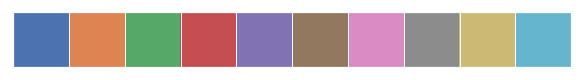

In [2]:
# Import useful data science libraries

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()

from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import Ridge
from sklearn import metrics

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

# Customize default chart graphics
mpl.rcParams.update({
  'font.size': 14,
  'axes.titlesize': 'x-large',
  'axes.labelsize': 'large',
  'xtick.labelsize': 'medium',
  'ytick.labelsize': 'medium',
  'legend.fancybox': True,
  'legend.fontsize': 'medium',
  'legend.frameon': True,
  'legend.framealpha': 0.7,
  'figure.figsize': ['9', '6'],
})

# It's useful to have some named colors handy
(SNS_BLUE, SNS_ORANGE, SNS_GREEN,
 SNS_RED, SNS_PURPLE, SNS_BROWN,
 SNS_PINK, SNS_GRAY, SNS_YELLOW,
 SNS_CYAN) = sns.color_palette()
sns.palplot(sns.color_palette())

# Watermark extension to print version/system information
# Flags:
# -a [author] --v (python/ipython versions) -d (date)
# -t (time) -z (timezone) -r (repo)
# -g (git hash) -w (watermark version)
# -p [packages] (package info)
%load_ext watermark
%watermark -a 'Everett Wetchler' -v -d -t -z -w -p numpy,pandas,matplotlib,seaborn

####################################################
# END Boilerplate
####################################################

In [3]:
from IPython.display import Image

In [4]:
from cStringIO import StringIO
import time
import os.path
import urllib

import fiona
from matplotlib import gridspec
from osgeo import gdal, ogr, osr
from retrying import retry
from scipy import misc, ndimage

gdal.UseExceptions()

<div style="background-color: #008000;height: 20px"></div>

# 1. Download satellite night lights images from NOAA

- **INPUT**:
 - None
- **OUTPUT**: 
 - `F182010.v4d_web.stable_lights.avg_vis.tif`: Single image file giving nightlights intensity around the world

Go to the [DMSP-OLS website](https://ngdc.noaa.gov/eog/dmsp/downloadV4composites.html) and download the satellite nighttime luminosity data (roughly 400MB). We will use the one from 2010. The archive they provide constains several files. Feel free to explore these files. We will only be using the file F182010.v4d_web.stable_lights.avg_vis.tif.

A code snippet to get you started is below. Plot a map of nightlight luminosity in Rwanda.

In [5]:
Image('data/satellite/F182010.v4/F182010.v4d_web.stable_lights.avg_vis_smaller.png')

<div style="background-color: #008000;height: 20px"></div>

# 2. Download Rwandan DHS and construct cluster-level aggregates

- **INPUT**: 
  - `rwanda_clusters_location.csv`: Coordinates of the centroid of each cluster
- **OUTPUT**: 
  - `rwanda_cluster_avg_asset_2010.csv`: Comma-delimited file indicated average wealth of each cluster 

[Demographic and Health Surveys (DHS)](http://dhsprogram.com/What-We-Do/Survey-Types/DHS.cfm) are nationally-representative household surveys that provide data for a wide range of monitoring and impact evaluation indicators in the areas of population, health, and nutrition. For this assignment, you will need to download the [2010 Rwandan DHS data](http://dhsprogram.com/what-we-do/survey/survey-display-364.cfm). **This requires registration, so start early!** Do not forget to request for the GPS dataset. Make sure you understand the structure of the data before starting.

Your immediate goal is to take the raw survey data, covering 12,540 households, and compute the average household wealth for each survey cluster (think of a cluster as a village). Refer to the file `Recode6_DHS_22March2013_DHSG4.pdf` for information on these data.

Save your output as `rwanda_cluster_avg_asset_2010.csv` and check that it matches the file that we have provided. You will use this file as input to the next step in the assignment.

Conduct some basic statistical analysis of these data, for instance to show the wealth distribution of rwanda (e.g., as a histogram). If you have time, create a map showing the spatial distribution of wealth of Rwanda, as calculated from the DHS. Intpret this analysis -- what have you learned about the distribution of wealth in Rwanda?

Hints:
- `Household Recode` contains all the attributes of each household. It provides datasets with different formats. Feel free to explore the data. You can use `RWHR61FL.DAT` file in Flat ASCII data (.dat) format.
- `RWHR61FL.DCF` describes the attributes and the location of each attribute.
- Geographic Datasets: `rwge61fl.zip` contains the location of each cluster in Rwanda. It is in the format of shapefile, which needs QGIS or other GIS softwares to open. For those who are not familiar with GIS tools or who want a shortcut, you can also sue the file `rwanda_clusters_location.csv` provided with the problem set.

For reference, the cluster locations, overlaid on the nightlights data, are shown in the figure below.
<img src="figure/map1.png" alt="Map" style="width: 600px;"/>

### A. Dataset construction

Notes from `Recode6_DHS_22March2013_DHSG4.pdf`:
* HV001: Cluster number
* HV271: Household Wealth Index "Wealth index factor score (5 decimals)"
  * (so we need to divide by 100,000 to include implicit decimals)

In [6]:
# Load survey data, takes a minute
df_stata = pd.read_stata('data/survey/Rwanda_2010_Stata/RWHR61DT/RWHR61FL.DTA')
print(df_stata.shape)

(12540, 3396)


In [7]:
# Make a copy of the original (so we don't have to load it again if we need to start over)
df_survey = df_stata.copy()

In [8]:
# Restrict to useful columns, and rename them intelligibly
df_survey = df_survey[['hv001', 'hv005', 'hv270', 'hv271']]
df_survey.columns = ['cluster', 'weight', 'wealth_cat', 'wealth']

# Remove implicit decimals, converting columns to floats per documentation
df_survey['weight'] /= 1e6  # "an 8 digit variable with 6 implied decimal places"
df_survey['wealth'] /= 1e5  # "Wealth index factor score (5 decimals)"
df_survey.head()

,cluster,weight,wealth_cat,wealth
0,121,0.737365,richest,3.07037
1,121,0.737365,richest,1.48863
2,121,0.737365,richest,1.93735
3,121,0.737365,richer,0.14170
4,121,0.737365,richer,-0.07971


In [9]:
# These should be very nearly equal, per definition of HV005:
# "All sample weights are normalized such that the weighted
# number of cases is identical to the unweighted number of
# households when using the full dataset with no selection."
df_survey['weight'].sum(), len(df_survey)

(12539.999762, 12540)

In [10]:
# It seems all surveys in a given cluster have the same weight.
cluster_to_num_unique_weights = (pd.crosstab(df_survey['cluster'], df_survey['weight']) != 0).sum(axis=1)
df_weights = pd.DataFrame(sorted(set(zip(df_survey.cluster, df_survey.weight))), columns=['cluster', 'weight'])
df_weights.set_index('cluster', drop=True, inplace=True)
df_weights['unique_weights'] = cluster_to_num_unique_weights
df_weights.head(10)

,weight,unique_weights
cluster,,
1,0.886881,1
2,1.253747,1
3,0.943757,1
4,1.085467,1
5,0.988271,1
6,0.587649,1
7,1.119767,1
8,0.903820,1
9,0.583417,1


In [11]:
# Pick a random cluster to demonstrate that all households share the same weight
df_survey[df_survey['cluster'] == 10]

,cluster,weight,wealth_cat,wealth
9771,10,0.920109,richer,-0.08611
9772,10,0.920109,richer,0.15480
9773,10,0.920109,richest,2.31936
9774,10,0.920109,richer,0.05646
9775,10,0.920109,richer,0.10506
9776,10,0.920109,richer,-0.12835
9777,10,0.920109,richest,0.26849
9778,10,0.920109,poorer,-0.41377
9779,10,0.920109,middle,-0.36263
9780,10,0.920109,richer,-0.18853


In [12]:
# Sanity check - ensure wealth categories are non-overlapping
# and correctly-ascending
low = df_survey.groupby('wealth_cat')['wealth'].min()
hi = df_survey.groupby('wealth_cat')['wealth'].max()
pd.DataFrame([low, hi], index=['low', 'high']).T

,low,high
wealth_cat,,
poorest,-1.65339,-0.55246
poorer,-0.55241,-0.40322
middle,-0.40316,-0.21859
richer,-0.21844,0.22171
richest,0.22227,8.33051


In [13]:
df_survey.set_index('cluster', inplace=True, drop=False)
df_survey.head()

,cluster,weight,wealth_cat,wealth
cluster,,,,
121,121,0.737365,richest,3.07037
121,121,0.737365,richest,1.48863
121,121,0.737365,richest,1.93735
121,121,0.737365,richer,0.14170
121,121,0.737365,richer,-0.07971


In [14]:
# Read cluster lat/long data
df_locations = pd.read_csv('provided/rwanda_clusters_location.csv')
df_locations['DHSCLUST'] = df_locations['DHSCLUST'].astype(int)
df_locations.head()

,X,Y,DHSID,DHSCC,DHSYEAR,DHSCLUST,CCFIPS,ADM1FIPS,ADM1FIPSNA,ADM1SALBNA,ADM1SALBCO,ADM1DHS,ADM1NAME,DHSREGCO,DHSREGNA,SOURCE,URBAN_RURA,LATNUM,LONGNUM,ALT_GPS,ALT_DEM,DATUM
0,29.684726,-2.532818,RW201000000001,RW,2010.0,1,RW,RW15,Southern,NaN,NaN,2.0,South,7.0,Huye,GPS,R,-2.532818,29.684726,1706.0,1702.0,WGS84
1,30.310689,-1.833858,RW201000000002,RW,2010.0,2,RW,RW11,Eastern,NaN,NaN,5.0,East,26.0,Gatsibo,GPS,R,-1.833858,30.310689,1631.0,1631.0,WGS84
2,29.478298,-1.888155,RW201000000003,RW,2010.0,3,RW,RW14,Western,NaN,NaN,3.0,West,16.0,Ngororero,GPS,R,-1.888155,29.478298,2310.0,2324.0,WGS84
3,30.521692,-2.366763,RW201000000004,RW,2010.0,4,RW,RW11,Eastern,NaN,NaN,5.0,East,28.0,Kirehe,GPS,R,-2.366763,30.521692,1388.0,1399.0,WGS84
4,30.018541,-2.171266,RW201000000005,RW,2010.0,5,RW,RW11,Eastern,NaN,NaN,5.0,East,30.0,Bugesera,GPS,R,-2.171266,30.018541,1437.0,1445.0,WGS84


In [16]:
df_final = df_locations[['DHSCLUST', 'X', 'Y']]
df_final.set_index('DHSCLUST', inplace=True, drop=False)

# You can do this since they share the same index
df_final['wealth'] = df_survey.groupby(level=0)['wealth'].median()

# Let's format it to match the given solution file

# Rename columns
df_final.columns = ['cluster', 'longitude', 'latitude', 'wlthindf']  # Rename
df_final = df_final[['cluster', 'wlthindf', 'latitude', 'longitude']]  # Reorder
df_final.head()

/Users/everettwetchler/src/bdd/venv/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,cluster,wlthindf,latitude,longitude
DHSCLUST,,,,
1,1,-0.531405,-2.532818,29.684726
2,2,-0.409830,-1.833858,30.310689
3,3,-0.478115,-1.888155,29.478298
4,4,-0.435960,-2.366763,30.521692
5,5,-0.449480,-2.171266,30.018541


In [17]:
df_solution = pd.read_csv('/Users/everettwetchler/src/bdd/PS1/intermediate_files/rwanda_cluster_avg_asset_2010.csv')
df_solution.set_index('cluster', inplace=True, drop=False)
df_solution.head()

,cluster,wlthindf,latitude,longitude
cluster,,,,
1,1,-0.531405,-2.532818,29.684726
2,2,-0.409830,-1.833858,30.310689
3,3,-0.478115,-1.888155,29.478298
4,4,-0.435960,-2.366763,30.521692
5,5,-0.449480,-2.171266,30.018541


In [18]:
# Make sure the cluster numbers and locations match, at least
# As you'll see, our wealth index computations fail
for col in df_solution.columns:
    errors = abs(df_final[col] - df_solution[col])
    matches = (errors < 1e-7).sum()  # Allow for tiny floating point errors
    print("%s %s given solution" % (col, 'matches' if matches else 'DOES NOT MATCH'))

cluster matches given solution
wlthindf matches given solution
latitude matches given solution
longitude matches given solution


### B. Exploratory Data Analysis
> Conduct some basic statistical analysis of these data, for instance to show the wealth distribution of rwanda (e.g., as a histogram). If you have time, create a map showing the spatial distribution of wealth of Rwanda, as calculated from the DHS. Intpret this analysis -- what have you learned about the distribution of wealth in Rwanda?

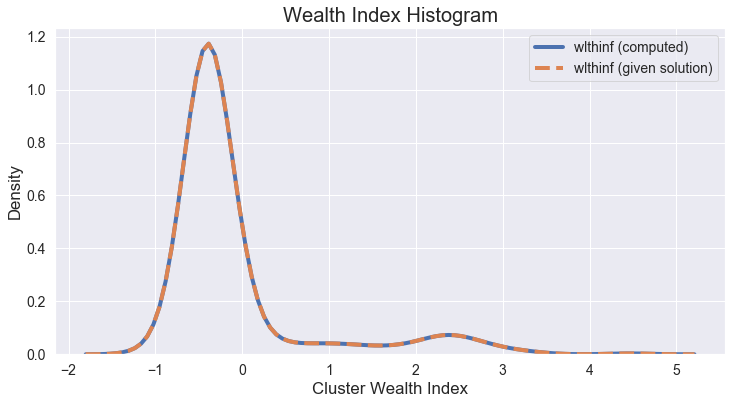

In [19]:
fig, ax = plt.subplots(1)
fig.set_size_inches(12, 6)
sns.kdeplot(df_final['wlthindf'], ax=ax, linewidth=4, label='wlthinf (computed)')
sns.kdeplot(df_solution['wlthindf'], ax=ax, linewidth=4, label='wlthinf (given solution)', linestyle='--')

ax.set_title("Wealth Index Histogram")
ax.set_xlabel("Cluster Wealth Index")
ax.set_ylabel("Density")
ax.legend()
fig.savefig('wealth_index.png')

In [20]:
df_final.to_csv('data/computed_rwanda_cluster_avg_asset_2010.csv', index=False)

<div style="background-color: #800000;height: 20px"></div>

## Observations
* Wealth distribution appears to be bimodal:
  1. Large poor population ~normally distributed just under 0
  2. Small wealthy population ~normally distributed around 2.5

<div style="background-color: #008000;height: 20px"></div>

# 3. Test whether night lights data can predict wealth, as observed in DHS

Now that you have "ground truth" measures of average cluster wealth, your goal is to understand whether the nightlights data can be used to predict wealth. First, merge the DHS and nightlights data, and then fit a model of wealth on nightlights.

<div style="background-color: #000080;height: 20px"></div>

## 3.1 Merge nightlights and DHS data at cluster level
- **INPUT**: 
 - `F182010.v4d_web.stable_lights.avg_vis.tif`: Nightlights data, from Step 1
 - `rwanda_cluster_avg_asset_2010.csv`: DHS cluster averages, from Step 2
- **OUTPUT**: Merged datasets
 - `DHS_nightlights.csv`: Merged dataset with 492 rows, and 6 columns (one indicates average cluster wealth, 5 nightlights features)
 - Scatterplot of nightlights vs. DHS wealth

Perform a "spatial join" to compute the average nighttime luminosity for each of the DHS clusters. To do this, you should take the average of the luminosity values for the nightlights locations surrounding the cluster centroid.

Save your output as `DHS_nightlights.csv` and check that it is the same as the file we have provided.

Create a scatterplot showing the relationship between average cluster wealth (y-axis) and average nighttime luminosity (x-axis). Your scatterplot should have one dot for each of the 492 DHS clusters. Report the R^2 of the regression line.

Hints:
 - The resolution of each pixel in the nightlight image is about 1km. Use 10 pixels X 10 pixels to average the luminosity of each cluster.
 - Start by just taking the **Mean** of the luminosity in the 100 pixels and comparing this to cluster average wealth. If you like, you could also compute other luminosity characteristics of each cluster, such as the **Max**, **Min**, **Standard Deviation** of the 100 pixel values, but this step is not required. Note that the file we provide (`DHS_nightlights.csv`) has these added features.
 - To read the raw raster (nightlights) files, we recommend using the GDAL library. Use `conda install gdal` to install the GDAL library. We have provided some helper code for this below.

In [21]:
# Helper function to read a raster file
def read_raster(raster_file):
    """
    Function
    --------
    read_raster

    Given a raster file, get the pixel size, pixel location, and pixel value

    Parameters
    ----------
    raster_file : string
        Path to the raster file

    Returns
    -------
    x_size : float
        Pixel size
    top_left_x_coords : numpy.ndarray  shape: (number of columns,)
        Longitude of the top-left point in each pixel
    top_left_y_coords : numpy.ndarray  shape: (number of rows,)
        Latitude of the top-left point in each pixel
    centroid_x_coords : numpy.ndarray  shape: (number of columns,)
        Longitude of the centroid in each pixel
    centroid_y_coords : numpy.ndarray  shape: (number of rows,)
        Latitude of the centroid in each pixel
    bands_data : numpy.ndarray  shape: (number of rows, number of columns, 1)
        Pixel value
    """
    raster_dataset = gdal.Open(raster_file, gdal.GA_ReadOnly)
    # get project coordination
    proj = raster_dataset.GetProjectionRef()
    bands_data = []
    # Loop through all raster bands
    for b in range(1, raster_dataset.RasterCount + 1):
        band = raster_dataset.GetRasterBand(b)
        bands_data.append(band.ReadAsArray())
        no_data_value = band.GetNoDataValue()
    bands_data = np.dstack(bands_data)
    rows, cols, n_bands = bands_data.shape

    # Get the metadata of the raster
    geo_transform = raster_dataset.GetGeoTransform()
    (upper_left_x, x_size, x_rotation, upper_left_y, y_rotation, y_size) = geo_transform
    
    # Get location of each pixel
    x_size = 1.0 / int(round(1 / float(x_size)))
    y_size = - x_size
    y_index = np.arange(bands_data.shape[0])
    x_index = np.arange(bands_data.shape[1])
    top_left_x_coords = upper_left_x + x_index * x_size
    top_left_y_coords = upper_left_y + y_index * y_size
    # Add half of the cell size to get the centroid of the cell
    centroid_x_coords = top_left_x_coords + (x_size / 2)
    centroid_y_coords = top_left_y_coords + (y_size / 2)

    return (x_size, top_left_x_coords, top_left_y_coords, centroid_x_coords, centroid_y_coords, bands_data)

In [22]:
# Helper function to get the pixel index of the point
def get_cell_idx(lon, lat, top_left_x_coords, top_left_y_coords):
    """
    Function
    --------
    get_cell_idx

    Given a point location and all the pixel locations of the raster file,
    get the column and row index of the point in the raster

    Parameters
    ----------
    lon : float
        Longitude of the point
    lat : float
        Latitude of the point
    top_left_x_coords : numpy.ndarray  shape: (number of columns,)
        Longitude of the top-left point in each pixel
    top_left_y_coords : numpy.ndarray  shape: (number of rows,)
        Latitude of the top-left point in each pixel
    
    Returns
    -------
    lon_idx : int
        Column index
    lat_idx : int
        Row index
    """
    lon_idx = np.where(top_left_x_coords < lon)[0][-1]
    lat_idx = np.where(top_left_y_coords > lat)[0][-1]
    return lon_idx, lat_idx

In [25]:
# this illustrates how you can read the nightlight image
raster_file = 'data/night_lights/F182010.v4/F182010.v4d_web.stable_lights.avg_vis.tif'
x_size, top_left_x_coords, top_left_y_coords, centroid_x_coords, centroid_y_coords, bands_data = read_raster(raster_file)

# save the result in compressed format - see https://docs.scipy.org/doc/numpy/reference/generated/numpy.savez.html
np.savez('data/nightlight.npz', top_left_x_coords=top_left_x_coords, top_left_y_coords=top_left_y_coords, bands_data=bands_data)

In [26]:
# Load NPZ data file
npz = np.load('data/nightlight.npz')
top_left_x_coords = npz['top_left_x_coords']
top_left_y_coords = npz['top_left_y_coords']
bands_data = npz['bands_data']

## Explore these new functions and data

In [27]:
print("Pixel size: %f" % x_size)
print("There are %d x (longitude) values" % len(top_left_x_coords))
print("There are %d y (latitude) values" % len(top_left_y_coords))
print("bands_data shape is %s" % str(bands_data.shape))

Pixel size: 0.008333
There are 43201 x (longitude) values
There are 16801 y (latitude) values
bands_data shape is (16801, 43201, 1)


Text(0,0.5,'latitude value')

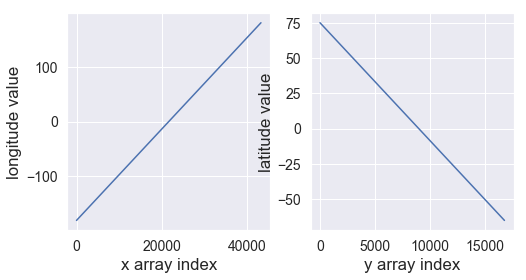

In [28]:
# What do these x and y arrays look like? Apparently equi-spaced:

fig, axes = plt.subplots(1, 2)
fig.set_size_inches(8, 4)
ax = axes[0]
ax.plot(top_left_x_coords)
ax.set_xlabel("x array index")
ax.set_ylabel("longitude value")
ax = axes[1]
ax.plot(top_left_y_coords)
ax.set_xlabel("y array index")
ax.set_ylabel("latitude value")

In [29]:
# Test: this should return the first cell, (0, 0)
lat = max(centroid_y_coords)
lon = min(centroid_x_coords)
get_cell_idx(lon, lat, top_left_x_coords, top_left_y_coords)

(0, 0)

## Begin solution code

In [30]:
def get_area_luminosity_values(lon, lat):
    '''Return list of luminosity values for pixels within 10km of a point.'''
    x, y = get_cell_idx(lon, lat, top_left_x_coords, top_left_y_coords)

    # We want a 10x10 square of pixels, meaning the central pixel plus
    # 9 others. This odd number doesn't evenly flank our central pixel.
    # After experimenting, it seems the existing data simply takes
    # 5 pixels left/above and 4 pixels right/below, though we should
    # really be computing which boundary it's closer to (commented out code)
    x_start = x - 5
    y_start = y - 5
#     if x < len(top_left_x_coords - 1):
#         #   (distance to left pixel edge) > (distance to right pixel edge)
#         if abs(lon - top_left_x_coords[x]) > abs(lon - top_left_x_coords[x + 1]):
#             x_start += 1
#     if y < len(top_left_y_coords - 1):
#         #   (distance to top pixel edge) > (distance to bottom pixel edge)
#         if abs(lat - top_left_y_coords[y]) > abs(lat - top_left_y_coords[y + 1]):
#             y_start += 1
    x_end = x_start + 10
    y_end = y_start + 10
    
    # Drop pixels that are off the map edge
    x_start = max(0, x_start)
    y_start = max(0, y_start)
    x_end = min(x_end, len(top_left_x_coords))
    y_end = min(y_end, len(top_left_y_coords))

    luminosities = []
    for xx in range(x_start, x_end):
        for yy in range(y_start, y_end):
            luminosities.append(bands_data[yy][xx][0])
    return luminosities

In [31]:
# Build our complete dataframe for modelling
d = df_solution.T.to_dict()

for cluster, values in d.items():
    lums = get_area_luminosity_values(values['longitude'], values['latitude'])
    values.update({
        'max_': np.max(lums),
        'mean_': np.mean(lums),
        'median_': np.median(lums),
        'min_': np.min(lums),
        'std_': np.std(lums),
    })
    del values['longitude']
    del values['latitude']
    for a, b in (('cluster', 'id'), ('wlthindf', 'wealth')):
        values[b] = values[a]
        del values[a]

df = pd.DataFrame.from_dict(d).T
df.reset_index(inplace=True, drop=True)
df.head()

,id,max_,mean_,median_,min_,std_,wealth
0,1.0,6.0,0.06,0.0,0.0,0.596992,-0.531405
1,2.0,0.0,0.00,0.0,0.0,0.000000,-0.409830
2,3.0,0.0,0.00,0.0,0.0,0.000000,-0.478115
3,4.0,0.0,0.00,0.0,0.0,0.000000,-0.435960
4,5.0,0.0,0.00,0.0,0.0,0.000000,-0.449480


In [32]:
# See if our dataframe matches the key given to us
# (allowing some error for floating point math)
key = pd.read_csv('intermediate_files/DHS_nightlights.csv')
key.head()

,id,max_,mean_,median_,min_,std_,wealth
0,1.0,6.0,0.06,0.0,0.0,0.596992,-0.531405
1,2.0,0.0,0.00,0.0,0.0,0.000000,-0.409830
2,3.0,0.0,0.00,0.0,0.0,0.000000,-0.478115
3,4.0,0.0,0.00,0.0,0.0,0.000000,-0.435960
4,5.0,0.0,0.00,0.0,0.0,0.000000,-0.449480


In [33]:
# These should be zero for all columns
((df - key) > 1e-8).sum()

id         0
max_       0
mean_      0
median_    0
min_       0
std_       0
wealth     0
dtype: int64

Text(0.5,1,'Luminosity vs wealth, $r^2$=0.74')

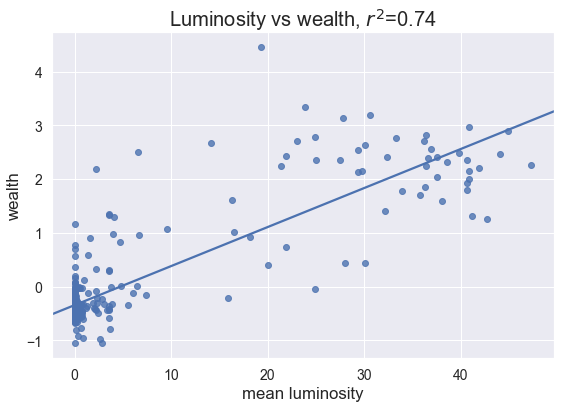

In [34]:
x = df.mean_
y = df.wealth
r2 = x.corr(y) ** 2

fig, ax = plt.subplots(1)
sns.regplot(x, y, ci=None, ax=ax)
ax.set_xlabel("mean luminosity")
ax.set_title("Luminosity vs wealth, $r^2$=%.2f" % r2)

<div style="background-color: #000080;height: 20px"></div>

## 3.2. Fit a model of wealth as a function of nightlights
- **INPUT**: 
 - `DHS_nightlights.csv`, from Step 3.1
- **OUTPUT**: 
 - R^2 of model
 
Above, you fit a regression line to illustrate the relationship between cluster average wealth and corresponding cluster nightlights. Now, use [cross-validation](https://en.wikipedia.org/wiki/Cross-validation_%28statistics%29) to get a better sense of out of sample accuracy. Report the cross-validated accuracy (R^2); how does it compare to the accuracy you reported in 3.1? How do you interpret these differences?

There are two options for this. The basic way, for those new to machine learning, is to randomly divide your dataset into a training and a test dataset. Randomly select 80% of your clusters and fit a model of cluster-average DHS wealth (your response/dependent variable) on nightlights (your predictor/independent variables). You can use a regression or any other model you prefer. Then, use that model to predict the wealth of the remaining 20% of your data, and compare the predicted values to the actual values, and report the R^2 on these 20%.

The preferred way is to use 10-fold cross-validation, where you repeat the above procedure 10 times, so that you have 10 different and non-overlapping test sets. Then, you report the cross-validated R^2 of your model (i.e., the average R^2 of your 10 test folds).

Hints:
 - The scikit learn library has built-in functions for [cross-validation](http://scikit-learn.org/stable/modules/cross_validation.html) that make this quite easy.
 


Mean r²=0.720 (std 0.120)


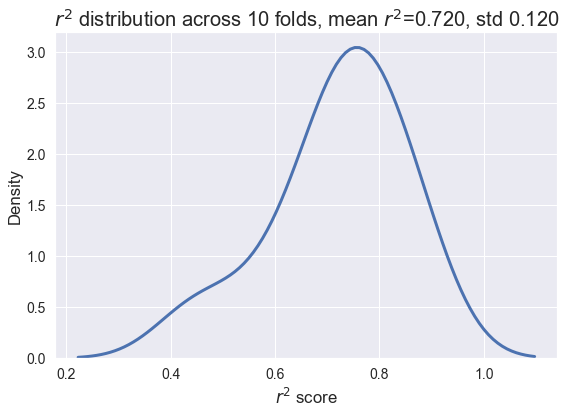

In [35]:
X = df[['mean_']].values
y = df['wealth'].values

scores = cross_val_score(Ridge(), X, y, cv=10, scoring='r2')
mu = np.mean(scores)
sd = np.std(scores)
print("Mean r²=%.3f (std %.3f)" % (mu, sd))

fig, ax = plt.subplots(1)
sns.kdeplot(scores, ax=ax, linewidth=3)
ax.set_xlabel('$r^2$ score')
ax.set_ylabel('Density')
ax.set_title("$r^2$ distribution across 10 folds, mean $r^2$=%.3f, std %.3f" % (mu, sd))
pass

<div style="background-color: #800000;height: 20px"></div>

## Observations
* The mean r² score is slightly lower than the overall r², which makes sense as the overall r² fits to the full data and therefore overfits to some extent.
* The variance in r² scores is higher than I expected - meaning the model can be substantially less accurate for any given subset of clusters (~50 in each fold here).

# 4. Download daytime satellite imagery 
- **INPUT**: 
 - Google Maps API key
 - `Sector_Boundary_2012.shp`: Rwandan shapefile
- **OUTPUT**: 
 - Thousands of satellite images (store in directory `google_image/`)

We will use the Google Static Maps API to download satellite images. Refer to the [Google Static Maps introduction](https://developers.google.com/maps/documentation/maps-static/dev-guide) and [Google Static Maps API Usage Limits](https://developers.google.com/maps/documentation/static-maps/usage-limits). You must apply for an API key before downloading. ** Note that it may take you several days to download the required images, so start early!**

Download the images from Google at zoom level 16 (pixel resolution is about 2.5m). Set the image size to be 400 pixels X 400 pixels, so that each image you download will cover 1 square kilometer. In this way, each daytime image you download will correspond to a single pixel from the nighttime imagery from Step 1 above.

Note: The Google Map API requires that you "enable billing on each of your projects." Note that "when you enable billing, you get \$200 free usage every month for Maps, Routes, or Places. Based on the millions of users using our APIs today, most of them can continue to use Google Maps Platform for free with this credit." ([ref](https://cloud.google.com/maps-platform/user-guide/pricing-changes/)) For this problem set, you will need to download about 50,000 -- this costs about \$100. So the \$200 free usage every month should be enough, as long as you are careful :) Remember to set a budget alert to track how your spend is growing toward a particular amount ([ref](https://cloud.google.com/billing/docs/how-to/budgets)).

Hints:
 - You will need to tell Google the locations for which you wish to download images. One way to do this is to use a [shapefiles](https://en.wikipedia.org/wiki/Shapefile) that specifies the borders of Rwanda. We have provided this shapefile (`Sector_Boundary_2012.shp`) as well as a helper function to read in the shapefile.
 - The function we provide below does not limit the maximum number of images downloaded per day. Note that if you attempt to  download more than the daily limit, Google will return blank images instead of an error.
 - You can organize the files however you like. However, for later analysis (Steps 6 and beyond), it may help if you organize these daytime images into 64 folders, with one folder indicating the nightlight intensity of the pixel corresponding to the daytime image. In other words, if you download a daytime image for which the corresponding nighttime pixel has value 32, store that daytime image in a folder labeled '32'. This way, all the satellite images within each folder will have the same nightlight intensity. The file name is columnIndex_rowIndex.jpg, in which row index and column index are the index in the nightlight image (See the diagram below).

![title](figure/data_description.png)

In [37]:
# Helper function to read a shapefile
def get_shp_extent(shp_file):
    """
    Function
    --------
    get_shp_extent

    Given a shapefile, get the extent (boundaries)

    Parameters
    ----------
    shp_file : string
        Path to the shapefile
    
    Returns
    -------
    extent : tuple
        Boundary location of the shapefile (x_min, y_min, x_max, y_max)
    """
    shape = fiona.open(shp_file)
    extent = shape.bounds
    return extent

In [38]:
import urllib2

In [39]:
# Helper functions to download images from Google Maps API

# Stop after trying 10 times
@retry(stop_max_attempt_number=10)
def save_img(url, file_path, file_name, timeout=5):
    """
    Function
    --------
    save_img

    Given a url of the map, save the image

    Parameters
    ----------
    url : string
        URL of the map from Google Map Static API
    file_path : string
        Folder name of the map
    file_name : string
        File name
    
    Returns
    -------
    None
    """
    a = urllib2.urlopen(url, timeout=5).read()
    b = StringIO(a)
    image = ndimage.imread(b, mode='RGB')
    # when no image exists, api will return an image with the same color. 
    # and in the center of the image, it said'Sorry. We have no imagery here'.
    # we should drop these images if large area of the image has the same color.
    if np.array_equal(image[:,:10,:],image[:,10:20,:]):
        pass
    else:
        # Chop of the top and bottom of the image, to remove watermarks
        misc.imsave(file_path + file_name, image[50:450, :, :])

In [40]:
# Now read in the shapefile for Rwanda and extract the edges of the country
inShapefile = "provided/Sector_Boundary_2012/Sector_Boundary_2012.shp"
x_min_shp, y_min_shp, x_max_shp, y_max_shp = get_shp_extent(inShapefile)
print(x_min_shp, y_min_shp, x_max_shp, y_max_shp)

(28.861730820284293, -2.8402301026069785, 30.89974664177404, -1.0471667072395556)


In [41]:
left_idx, top_idx = get_cell_idx(x_min_shp, y_max_shp, top_left_x_coords, top_left_y_coords)
right_idx, bottom_idx = get_cell_idx(x_max_shp, y_min_shp, top_left_x_coords, top_left_y_coords)
print(left_idx, top_idx, right_idx, bottom_idx)

(25063, 9126, 25308, 9341)


In [42]:
num_x = (right_idx - left_idx + 1)
num_y = (bottom_idx - top_idx + 1)
N = num_x * num_y
print("Fetching %d images (%d wide x %d high)" % (N, num_x, num_y))

Fetching 53136 images (246 wide x 216 high)


In [54]:
import hashlib
import hmac
import base64
import urlparse

In [56]:
def sign_url(input_url=None, secret=None):
  """ Sign a request URL with a URL signing secret.

      Usage:
      from urlsigner import sign_url

      signed_url = sign_url(input_url=my_url, secret=SECRET)

      Args:
      input_url - The URL to sign
      secret    - Your URL signing secret

      Returns:
      The signed request URL
  """

  if not input_url or not secret:
    raise Exception("Both input_url and secret are required")

  url = urlparse.urlparse(input_url)

  # We only need to sign the path+query part of the string
  url_to_sign = url.path + "?" + url.query

  # Decode the private key into its binary format
  # We need to decode the URL-encoded private key
  decoded_key = base64.urlsafe_b64decode(secret)

  # Create a signature using the private key and the URL-encoded
  # string using HMAC SHA1. This signature will be binary.
  signature = hmac.new(decoded_key, url_to_sign, hashlib.sha1)

  # Encode the binary signature into base64 for use within a URL
  encoded_signature = base64.urlsafe_b64encode(signature.digest())

  original_url = url.scheme + "://" + url.netloc + url.path + "?" + url.query

  # Return signed URL
  return original_url + "&signature=" + encoded_signature

In [60]:
z = None
try:
    a = urllib2.urlopen(sign_url(url, secret), timeout=5)
except urllib2.HTTPError, e:
    #a.read()
    print('errrrr')
    z = e
# save_img(url, './', 'tmp.png')

In [111]:
key = open('PRIVATE_GMAPS_API_KEY').read().strip()
secret = open('PRIVATE_GMAPS_SIGNATURE_SECRET').read().strip()
assert key
assert secret

In [113]:
# Note that we fetch a 400x500 image. This is because google adds a watermark
# to the bottom of every image. In order to get rid of this, we request images
# a bit taller than we want, then chop off the extra height (including the watermark).
m = 0
errors = []
for i in xrange(left_idx, right_idx + 1):
    for j in xrange(top_idx, bottom_idx + 1):
        lon = centroid_x_coords[i]
        lat = centroid_y_coords[j]
        url = 'https://maps.googleapis.com/maps/api/staticmap?center=' + str(lat) + ',' + \
               str(lon) + '&zoom=16&size=400x500&maptype=satellite&key=' + key
        url = sign_url(url, secret)
        lightness = bands_data[j, i, 0]
        file_path = 'google_image/' + str(lightness) + '/'
        if not os.path.isdir(file_path):
            os.makedirs(file_path)
        file_name = str(i) + '_' + str(j) +'.jpg'
        if os.path.isfile(os.path.join(file_path, file_name)):
            # Already fetched this one
            m += 1
            continue
        try:
            save_img(url, file_path, file_name)
        except Exception, e:
            print("ERROR on %d,%d" % (i, j))
            errors.append([i, j, url, file_path, file_name, e])
        if m % 100 == 0:
            print(time.time())
        m += 1
        print('(%d, %d) %d/%d fetched' % (i, j, m, N))

print("Finished with %d errors." % len(errors))
if errors:
    print('Rerun this cell to re-attempt the missing images.')

Finished with 0 errors.


In [90]:
luminosities = []
n_images = 0
for folder in os.listdir('google_image/'):
    if os.path.isdir('google_image/' + folder) and folder.isdigit():
        found = sum(1 for f in os.listdir('google_image/' + folder) if f.endswith('jpg'))
        luminosities.extend([int(folder)] * found)
        n_images += found

if n_images == N:
    print("Complete. Saved all %d images." % N)
    zeros = sum(1 for x in luminosities if x == 0)
    print("%.2f%% of images had zero luminosity at the central pixel" % (zeros * 100.0 / N))
else:
    print("INCOMPLETE: Saved %d images but expected %d" % (N, n_images))

Complete. Saved all 53136 images.
96.45% of images had zero luminosity at the central pixel


Text(0,0.5,'Number of images')

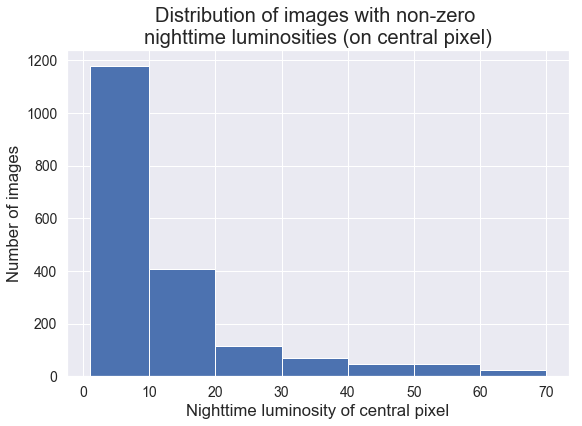

In [119]:
fig, ax = plt.subplots(1)
pd.Series([x for x in luminosities if x > 0]).hist(ax=ax, bins=[1,10,20,30,40,50,60, 70])
ax.set_title("Distribution of images with non-zero \nnighttime luminosities (on central pixel)")
ax.set_xlabel("Nighttime luminosity of central pixel")
ax.set_ylabel("Number of images")

# 5. Test whether basic features of daytime imagery can predict wealth
In step 3, you tested whether nightlight imagery could predict the wealth of Rwandan villages. You will now test whether daytime imagery can predict village wealth. Start by extracting simple metrics from the daytime imagery; in step 6 you will use more sophsticated methods to engineer these features from the images. **You don't need to do this step if you are able to do step 6.**

## 5.1. Extract "basic" features from daytime imagery
- **INPUT**: 
 - `google_image/...`: Raw images, from Step 4
- **OUTPUT**: 
 - `google_image_features_basic.csv`: Image features 

Convert the raw data from the satellite imagery into a set of features that can be used in a machine learning algorithm. A simple way to do this is to take the raw R/G/B values for each pixel and average them for the image. Thus, if an image has 100 pixels, you will have an average R value, an average G value, and an average B value. Create more features by also computing the min, max, median, and standard deviation of R, G, and B for each image. This process will convert each image into a vector of 15 features. Show three different histograms that indicate the distribution of average R/G/B values in your images.

Feel free to be creative if you wish to generate additional features from the imagery -- this is similar to the process described in section 2.3 of the paper's supplementary materials. But don't waste too much time, and don't expect these features to be terribly useful.

In [ ]:
#
# Your code here
#

## 5.2. Merge daytime images with DHS data

- **INPUT**: 
 - `google_image_features_basic.csv`: Satellite imagery features, from Step 5.1
 - `rwanda_cluster_avg_asset_2010.csv`: DHS cluster averages, from Step 2
- **OUTPUT**: Merged datasets
 - `data/model/DHS_daytime.csv`: Merged dataset with 492 rows, and 16 columns (one indicates average cluster wealth, 15 daytime image features)

Now that you have feature vectors for each image, you should merge these with the DHS data indicating average cluster wealth. Follow a similar procedure as you did with 3.1, i.e., determine which image feature vectors are associated with each cluster, and then calculate, for each cluster, the average value of each feature. 

Save your output as `DHS_daytime.csv` and check that it is roughly the same as the file we have provided. There may be slight differences if you chose to calculate a different set of features than those described in 5.1.

 - Show three histograms of the distribution of R/G/B values of the average cluster image features (in other words, each histogram should contain 492 points).
 - Create three scatterplots (one for each of the R/G/B channels) that shows how average color intensity of the cluster (x-axis) relates to average cluster wealth (y-axis). What do you observe?

In [ ]:
#
# Your code here
#


*Replace this section with your observations and interpretation*


## 5.3. Fit a model of wealth as a function of basic daytime features
- **INPUT**: 
 - `data/model/DHS_daytime.csv`, from Step 5.2
- **OUTPUT**: 
 - R^2 of model
 
As in 3.2, use 10-fold cross-validation to fit a model of cluster-level DHS wealth (your response/dependent variable) as a function of the nightlights data (your predictor/independent variables). Since you have a reasonably large number of predictor variables, you should use a model that incorporates some form of regularization (e.g., ridge regression, lasso regression, or a tree-based method).  Report the cross-validated R^2 of your model (i.e., the average R^2 of your 10 test folds).

How does this model's performance compare to that of the nightlights model? Can you think of any other ways (aside from deep learning) that you might use to improve the features being extracted from daytime imagery, which might improve the predictive performance of your model?

*Note:* Even if you do not choose to do parts 6-7, make sure you do parts 8 and 9!

In [ ]:
#
# Your code here
#


*Replace this section with your observations and interpretation*


<a id='step_6'></a>

# 6. *Optional*: Use deep learning to extract fancier features

This is where things get interesting. You will use existing libraries to extract more meaningful features from the daytime imagery, similar to what is shown in Fig. 2 of the paper.

## 6.1. Use the keras library to use a basic CNN to extract features of the daytime images 
 
- **INPUT**: 
 - `google_image/...`: Raw images, from Step 4
- **OUTPUT**: 
 - `google_image_features_cnn.csv`: Image features 

Begin by using a Convolutional Neural Network that has been pre-trained on ImageNet to extract features from the images. We recommend using the [`Keras` library](https://keras.io/), which provides a very straightforward interface to [TensorFlow](https://www.tensorflow.org/).

Hints:
 - This [short intro](https://github.com/fchollet/deep-learning-models/blob/master/README.md) will help you get started with extracting features from the CNN.

In [ ]:
#
# Your code here
#

# 6.2. Test whether these new features of satellite imagery can predict wealth
- **INPUT**: 
 - `google_image_features_cnn.csv`: Satellite imagery features, from Step 6.1
 - `rwanda_cluster_avg_asset_2010.csv`: DHS cluster averages, from Step 2
- **OUTPUT**: 
 - `data/model/DHS_daytime.csv`: Merged dataset with 492 rows, and 4097 columns (one indicates average cluster wealth, 4096 CNN-based features)
 - R^2 of model
 
Calculate the average value of each feature for each of the DHS clusters. As in Step 3.1 and 5.2, you will want to aggregate over images near the cluster centroid by taking the average value for each feature. Create a scatterplot showing the relationship between average cluster wealth (y-axis) and the first principal component of all of your image features (x-axis) - in other words, run PCA on your 4096 image features and plot the first PC on the x-axis. Your scatterplot should have one dot for each of the 492 DHS clusters.

Use 10-fold cross-validation to fit a model of cluster-level DHS wealth (your response/dependent variable) as a function of the "deep" features (your predictor/independent variables). Use a model that incorporates some form of regularization (e.g., ridge regression, lasso regression, or a tree-based method).  Report the cross-validated R^2 of your model (i.e., the average R^2 of your 10 test folds).

In [ ]:
from sklearn.decomposition import PCA
#
# Your code here
#

<a id='step_7'></a>

# 7. *Optional:* Replicate the transfer learning results of Jean et al (2016)

The only thing missing at this point is the "transfer learning" step. In other words, instead of using the image features extracted by the CNN directly, we want to retrain the CNN to predict nightlights from daytime imagery, and use those features, which presumably are more appropriate to our final prediction task.

## 7.1. Use the nightlights to retrain the CNN and extract features

- **INPUT**: 
 - `google_image/...`: Raw images, from Step 4
- **OUTPUT**: 
 - `google_image_features_cnn_retrained.csv`: Image features 

Following the approach used in the paper, first divide your daytime images into three groups, corresponding to images where the corresponding night-lights pixel is dim, medium, or bright. Use these values to define your groups: [0, 3), [3, 35), [35, 64). We have given you the code to do this below.

In [ ]:
#
# Your code here
#

## 7.2. Test whether "deep" features of satellite imagery can predict wealth
- **INPUT**: 
 - `google_image_cnn/...`: Satellite images from 7.1
- **OUTPUT**: 
 - `data/model/DHS_CNN.csv`: Merged dataset with 492 rows, and 4097 columns (one indicates average cluster wealth, 4096 CNN features)
 - R^2 of model

Repeat 6.2, except this time use the features generated from 7.1, i.e., the features that have been constructed after transfer learning. As in 6.2, show a scatterplot of the relationship between average cluster wealth (y-axis) and the first principal component of your image features. Then, report the cross-validated R^2 of your model (i.e., the average R^2 of your 10 test folds).

In [ ]:
#
# Your code here
#

<a id='step_8'></a>

# 8. Construct a high-resolution map of the  predicted wealth of Rwanda
- **INPUT**: 
 - Model, image features (data/model/features_all_predictimage_location.csv)
- **OUTPUT**: 
 - Map ('poverty_mapping.tiff')
 
Choose your favorite model from the three daytime-based models that you have trained above: 5.3 (basic daytime features), 6.2 (deep daytime features), or 7.2 (transfer-learned daytime features). Use this model to calculate the predicted wealth of every one of your original images. Create a heatmap showing the distribution of predicted wealth in Rwanda. With any luck, it will look something like this:
<img src="figure/pmap.png" alt="Map"/>

In [ ]:
#
# Your code here
#

<a id='step_9'></a>

## 9. Step back and interpret your results

Now that you are more intimately familiar with what is being done in the Jean et al. paper, provide some intelligent/critical commentary on what you think of the overall method. If you were going to set about predicting wealth from satellite imagery, is there anything you would do differently, or do you think the recipe established in the paper is as good as can be? Would you trust the maps you've generated, if you needed to use them for a research project or to make policy recommendations? What do you think the limits of this approach are?


*Replace this section with your observations and interpretation*
